In [1]:
from datetime import datetime
from pyquil.quil import Program
from pyquil.gates import H, RX, MEASURE, RZ, CPHASE, CNOT
from pyquil.api import get_qc
import numpy as np
from new_noise import add_noise_to_program, Calibrations
import matplotlib.pyplot as plt
from pyquil_for_azure_quantum import get_qpu

%env AZURE_QUANTUM_SUBSCRIPTION_ID=1f916067-8a1f-4734-b6d3-86c5f55cfffe
%env AZURE_QUANTUM_WORKSPACE_RG=AzureQuantum
%env AZURE_QUANTUM_WORKSPACE_NAME= nonlocal-new-ea
%env AZURE_QUANTUM_WORKSPACE_LOCATION=westus
%env LOG_LEVEL=DEBUG aspen M-2.ipynb

date = datetime.today().strftime('%d-%m-%y')

env: AZURE_QUANTUM_SUBSCRIPTION_ID=1f916067-8a1f-4734-b6d3-86c5f55cfffe
env: AZURE_QUANTUM_WORKSPACE_RG=AzureQuantum
env: AZURE_QUANTUM_WORKSPACE_NAME=nonlocal-new-ea
env: AZURE_QUANTUM_WORKSPACE_LOCATION=westus
env: LOG_LEVEL=DEBUG aspen M-2.ipynb


Adiabatic shift

In [11]:
def adiabatic_shift(qc, qubits, steps, numshots, noise=None, cal=None):
    p = Program()
    for i in range(qubits):
        p += H(i)

    angles=(np.pi/2)*np.array(range(1,steps+1))/(steps+1)
    for theta in angles:
        alpha = -np.cos(theta)
        beta = -np.sin(theta)
        for i in range(qubits-1) :
            p += RZ(beta,i)
            p += RZ(beta,i+1)
            p += CPHASE(-2*beta,i,i+1)
        for i in range(qubits):
            p += RX(alpha, i)

    p.declare('ro', 'BIT', qubits)
    for i in range(qubits):
        p += MEASURE(i, ("ro", i))
    p.wrap_in_numshots_loop(numshots)
    if noise is not None:
        if cal is not None:
            p = add_noise_to_program(qc, p, convert_to_native=False, calibrations=cal, noise_intensity=noise)
        else:
            p = add_noise_to_program(qc, p, convert_to_native=False, noise_intensity=noise)
        bitstrings = qc.run(p).readout_data.get("ro")
    else:
        exe = qc.compile(p)
        bitstrings = qc.run(exe).readout_data.get("ro")
    d = 0
    for i in bitstrings:
        for q in range(qubits-1):
            d += (i[q] != i[q+1])
    d /= numshots*(qubits-1)
    return d

def plot_results(simulations, noise_levels, real=None, log=False):
    # Get the current date and time
    current_datetime = datetime.now()

    # Format the date and time
    formatted_datetime = current_datetime.strftime('%Y-%m-%d_%H-%M-%S')


    plt.figure(figsize=(10, 6))
    if real is not None: plt.plot(real, linestyle='--', marker='o', label='Real')
    for idx, noise in enumerate(noise_levels):
        plt.plot(simulations[idx], linestyle='--', marker='o', label=f'Noise Intensity: {noise}')



    plt.xlabel('Number of steps')
    plt.ylabel('d')
    plt.legend()
    # Save the plot to a file
    plt.savefig('adiabatic_shift_' + formatted_datetime + '.png')


    if log:
        plt.figure(figsize=(10, 6))
        plt.plot(real, linestyle='--', marker='o', label='Real')
        for idx, noise in enumerate(noise_levels):
            plt.plot(simulations[idx], linestyle='--', marker='o', label=f'Noise Intensity: {noise}')

        plt.xlabel('Number of steps')
        plt.ylabel('Density of kinks')
        plt.legend()
        plt.yscale('log')
        plt.xscale('log')
        # Save the plot to a file
        plt.savefig('adiabatic_shift_log_' + formatted_datetime + '.png')

    # Display the plot in the interactive window (optional)
    plt.show()

    # Close the plot (recommended)
    plt.close()



def run_experiment(qc,qubits, numshots, maxN, noise_levels):
    qvm = get_qc(qc, as_qvm=True, execution_timeout=1000)
    cal = Calibrations(qvm)

    simulations = []
    for noise in noise_levels:
        temp_result = np.zeros(maxN)
        for i in range(maxN):
            temp_result[i] = adiabatic_shift(qvm, qubits=qubits, steps=i, numshots=numshots, noise=noise, cal=cal)
        simulations.append(temp_result)

    return simulations


In [3]:
qubits = 4
numshots = 10000
maxN = 31
noise_levels = [0, 0.1, 0.25,0.4 , 1]
qc = 'Aspen-M-3'

In [ ]:
qpu = get_qpu(qc)
real = np.zeros(11)
for i in range(11):
    real[i] = adiabatic_shift(qpu, qubits=qubits, steps=i, numshots=numshots)
plt.plot(real)
plt.show()

WARNING - EnvironmentCredential.get_token failed: EnvironmentCredential authentication unavailable. Environment variables are not fully configured.
Visit https://aka.ms/azsdk/python/identity/environmentcredential/troubleshoot to troubleshoot.this issue.
WARNING - ImdsCredential.get_token failed: ManagedIdentityCredential authentication unavailable, no response from the IMDS endpoint.
WARNING - ManagedIdentityCredential.get_token failed: ManagedIdentityCredential authentication unavailable, no response from the IMDS endpoint.
WARNING - VisualStudioCodeCredential.get_token failed: Failed to get Azure user details from Visual Studio Code.
WARNING - VSCodeCredential.get_token failed: Failed to get Azure user details from Visual Studio Code.
WARNING - AzureCliCredential.get_token failed: Azure CLI not found on path
WARNING - AzurePowerShellCredential.get_token failed: Az.Account module >= 2.2.0 is not installed


..........................................................................................................................

WARNING - EnvironmentCredential.get_token failed: EnvironmentCredential authentication unavailable. Environment variables are not fully configured.
Visit https://aka.ms/azsdk/python/identity/environmentcredential/troubleshoot to troubleshoot.this issue.
WARNING - ImdsCredential.get_token failed: ManagedIdentityCredential authentication unavailable, no response from the IMDS endpoint.
WARNING - ManagedIdentityCredential.get_token failed: ManagedIdentityCredential authentication unavailable, no response from the IMDS endpoint.
WARNING - VisualStudioCodeCredential.get_token failed: Failed to get Azure user details from Visual Studio Code.
WARNING - VSCodeCredential.get_token failed: Failed to get Azure user details from Visual Studio Code.
WARNING - AzureCliCredential.get_token failed: Azure CLI not found on path


In [5]:
simulations = run_experiment(qc, qubits, numshots, maxN, noise_levels)


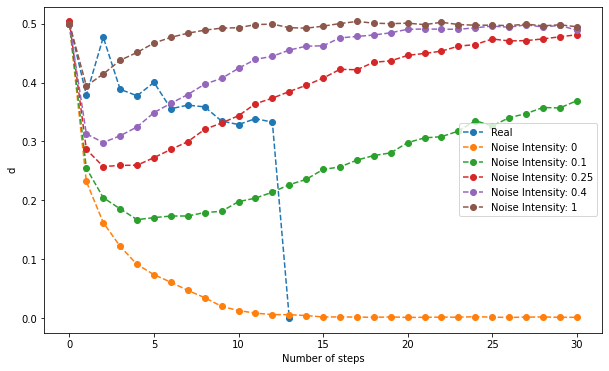

In [13]:
plot_results(simulations, noise_levels, real)

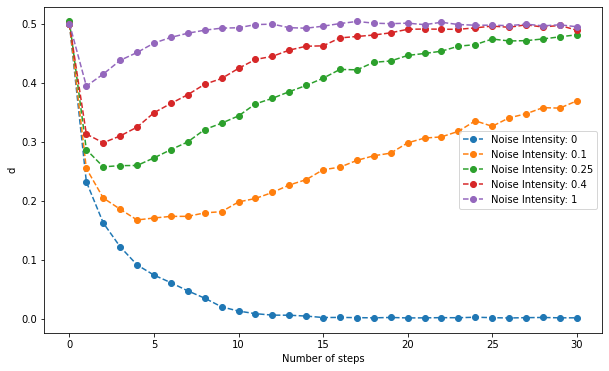

In [12]:
plot_results(simulations, noise_levels)

In [19]:
print(simulations)

[array([0.49926667, 0.23196667, 0.16216667, 0.12166667, 0.09093333,
       0.07363333, 0.0608    , 0.04686667, 0.0345    , 0.01976667,
       0.0126    , 0.0082    , 0.00573333, 0.00556667, 0.00413333,
       0.00166667, 0.00183333, 0.00146667, 0.00113333, 0.00176667,
       0.00096667, 0.00113333, 0.00143333, 0.0013    , 0.00216667,
       0.00143333, 0.0009    , 0.00143333, 0.00176667, 0.00113333,
       0.00116667]), array([0.49933333, 0.25453333, 0.20446667, 0.18543333, 0.16716667,
       0.17053333, 0.17326667, 0.17333333, 0.17923333, 0.18126667,
       0.19776667, 0.20363333, 0.21383333, 0.2265    , 0.23556667,
       0.2524    , 0.25676667, 0.26826667, 0.2761    , 0.2806    ,
       0.29803333, 0.3061    , 0.30813333, 0.31756667, 0.33543333,
       0.3261    , 0.34043333, 0.3473    , 0.3577    , 0.35696667,
       0.36916667]), array([0.50393333, 0.28653333, 0.25733333, 0.25936667, 0.25963333,
       0.2725    , 0.28646667, 0.2997    , 0.32063333, 0.3314    ,
       0.34376667, 

GHZ

In [ ]:
def ghz(qc, qubits, numshots, noise=False, cal=None, intensity=1):
    p = Program()
    p.declare("ro", "BIT", 3)
    p += H(qubits[0])
    p += CNOT(qubits[0], qubits[1])
    p += CNOT(qubits[1], qubits[2])
    p += MEASURE(qubits[0], ("ro", 0))
    p += MEASURE(qubits[1], ("ro", 1))
    p += MEASURE(qubits[2], ("ro", 2))
    p.wrap_in_numshots_loop(numshots)
    if noise:
        if cal is not None:
            p = add_noise_to_program(qc, p, calibrations=cal, noise_intensity=intensity)
        else:
            p = add_noise_to_program(qc, p, noise_intensity=intensity)
    return p

def run_experiment(qpu, qubits, numshots):
    qvm = get_qc(qpu, as_qvm=True, execution_timeout=1000)
    cal = Calibrations(qvm)
    no_noise = qvm.run(ghz(qvm,qubits,numshots, False)).readout_data.get("ro")
    noisy = qvm.run(ghz(qvm,qubits,numshots, True, cal)).readout_data.get("ro")


    qc = get_qpu(qpu)
    exe = qc.compile(ghz(qc,qubits,numshots, False), to_native_gates=True)
    real = qc.run(exe).readout_data.get("ro")
    return no_noise, noisy , real


def plot_results(results, label):
    # Initialize the histogram with all possible states and zero counts
    num_qubits = 3  # Adjust this to the number of qubits in your GHZ experiment
    histogram = {format(i, f"0{num_qubits}b"): 0 for i in range(2 ** num_qubits)}

    for i in results:
        code = ("00" + str(int(float(i[2]) * 100 + float(i[1]) * 10 + float(i[0]))))[-3:]
        histogram[code] = histogram.get(code, 0) + 1

    histogram = dict(sorted(histogram.items()))
    plt.bar(*zip(*histogram.items()), label=label)
    plt.xlabel('State')
    plt.ylabel('Counts')
    plt.legend()
    plt.show()

WARNING - EnvironmentCredential.get_token failed: EnvironmentCredential authentication unavailable. Environment variables are not fully configured.
Visit https://aka.ms/azsdk/python/identity/environmentcredential/troubleshoot to troubleshoot.this issue.
WARNING - ImdsCredential.get_token failed: ManagedIdentityCredential authentication unavailable, no response from the IMDS endpoint.
WARNING - ManagedIdentityCredential.get_token failed: ManagedIdentityCredential authentication unavailable, no response from the IMDS endpoint.
WARNING - VisualStudioCodeCredential.get_token failed: Failed to get Azure user details from Visual Studio Code.
WARNING - VSCodeCredential.get_token failed: Failed to get Azure user details from Visual Studio Code.
WARNING - AzureCliCredential.get_token failed: Azure CLI not found on path
WARNING - AzurePowerShellCredential.get_token failed: Az.Account module >= 2.2.0 is not installed


..............................................................................................

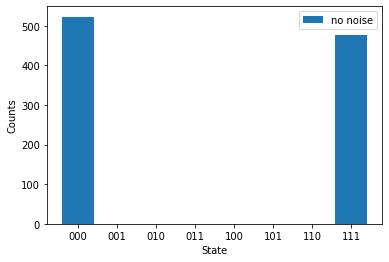

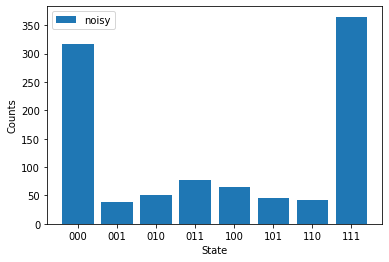

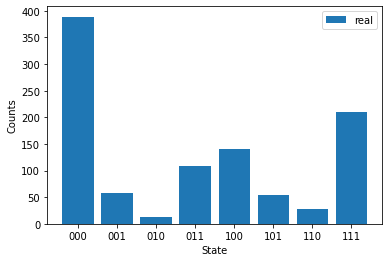

In [8]:
no_noise, noisy, real = run_experiment('Aspen-M-3',[0,1,2], 1000)
plot_results(no_noise, 'no noise')
plot_results(noisy, 'noisy')
plot_results(real, 'real')

For a given Program - p, and a given quantum computer qc, we can add noise to it using the following function:

In [1]:
no_noise, noisy, real = run_experiment('Aspen-M-3',[0,1,2], 1000)
plot_results(no_noise, 'no noise')
plot_results(noisy, 'noisy')
plot_results(real, 'real')

NameError: name 'run_experiment' is not defined

In [1]:
p = Program()
qc = get_qc('Aspen-M-3', as_qvm=True, execution_timeout=1000)
p = add_noise_to_program(
		qc =qc, # the quantum computer to mimic
		p= p, # the program to add noise to
		convert_to_native = True, # whether to convert the program to native gates, Note that this will delete delays
		calibrations = None, # a pre obtained calibrations to reduce the http requests or modify the wanted calibrations
		depolarizing = True, # whether to add depolarizing noise according to the fidelity calibration
		decoherence_after_1q_gate = False, # whether to add decoherence noise after every 1 qubit gate
		decoherence_after_2q_gate = True, # whether to add decoherence noise after every 2 qubit gate
		decoherence_only_on_targets = False, # whether to add decoherence noise only on the targets qubits of the gates
		readout_noise = True, # whether to add readout noise according to the readout calibration
		noise_intensity = 1.0 # the intensity of the noise, 1.0 is default, 0.0 is no noise
        )

NameError: name 'Program' is not defined

In [23]:
import numpy as np
from pyquil import Program
from pyquil.gates import RX, RZ, CZ

# Initialize a new quantum program
quantum_program = Program()

# Apply an RX(pi) gate on qubit 0
quantum_program += RX(np.pi, 0)

# Apply an RZ(pi/2) gate on qubit 1
quantum_program += RZ(np.pi / 2, 1)

# Apply a CZ gate with qubit 0 as control and qubit 1 as target
quantum_program += CZ(0, 1)

# Apply an RZ(pi/4) gate on qubit 2
quantum_program += RZ(np.pi / 4, 2)

# Apply a CZ gate with qubit 1 as control and qubit 2 as target
quantum_program += CZ(1, 2)

# Print the resulting quantum program
print(quantum_program)

qc = get_qc('Aspen-M-3', as_qvm=True)

noisy_quantum_program = add_noise_to_program(qc, quantum_program, convert_to_native=False)

print(noisy_quantum_program)

RX(pi) 0
RZ(pi/2) 1
CZ 0 1
RZ(pi/4) 2
CZ 1 2

DEFGATE Depolarizing_1Q_gate:
    1.0, 0
    0, 1.0

DEFGATE Depolarizing_CZ:
    1.0, 0, 0, 0
    0, 1.0, 0, 0
    0, 0, 1.0, 0
    0, 0, 0, 1.0

DEFGATE Damping_and_dephasing_for_2Q_gate:
    1.0, 0
    0, 1.0

RX(pi) 0
Depolarizing_1Q_gate 0
RZ(pi/2) 1
Depolarizing_1Q_gate 1
CZ 0 1
Depolarizing_CZ 0 1
Damping_and_dephasing_for_2Q_gate 2
RZ(pi/4) 2
Depolarizing_1Q_gate 2
CZ 1 2
Depolarizing_CZ 1 2
Damping_and_dephasing_for_2Q_gate 0
PRAGMA ADD-KRAUS Depolarizing_1Q_gate 0 "(0.9992632488008798 0.0 0.0 0.9992632488008798)"
PRAGMA ADD-KRAUS Depolarizing_1Q_gate 0 "(0.0 0.022158215902242293 0.022158215902242293 0.0)"
PRAGMA ADD-KRAUS Depolarizing_1Q_gate 0 "(0.0 -0.022158215902242293i 0.022158215902242293i 0.0)"
PRAGMA ADD-KRAUS Depolarizing_1Q_gate 0 "(0.022158215902242293 0.0 0.0 -0.022158215902242293)"
PRAGMA ADD-KRAUS Depolarizing_1Q_gate 1 "(0.9894955017766282 0.0 0.0 0.9894955017766282)"
PRAGMA ADD-KRAUS Depolarizing_1Q_gate 1 "(0.0 0.0

In [21]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.visualization import circuit_drawer

# Create a new quantum circuit with 3 qubits
qc = QuantumCircuit(3)

# Apply an RX(pi) gate on qubit 0
qc.rx(np.pi, 0)

# Apply an RZ(pi/2) gate on qubit 1
qc.rz(np.pi / 2, 1)

# Apply a CZ gate with qubit 0 as control and qubit 1 as target
qc.cz(0, 1)

# Apply an RZ(pi/4) gate on qubit 2
qc.rz(np.pi / 4, 2)

# Apply a CZ gate with qubit 1 as control and qubit 2 as target
qc.cz(1, 2)

# Draw the quantum circuit using the 'mpl' (matplotlib) option for a nicer diagram
circuit_drawer(qc, output='mpl')

MissingOptionalLibraryError: "The 'pylatexenc' library is required to use 'MatplotlibDrawer'. You can install it with 'pip install pylatexenc'."